In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Auxillary function declarations 

In [ ]:
N = 1024
dx = 1/N
dt = 1e-7
eps = 1e-14

# --- flux components ---
def h_xxx(h):
    """Compute third derivative using forward differences (periodic)."""
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    h_b2 = np.roll(h, 2)
    return (h_f1 - 3*h + 3*h_b1 - h_b2) / dx**3 

def f(h):
    return h**4 / (eps + h**3.5)

def a_gs(s1, s2):
    return f(0.5*(s1 + s2))

def da_gs(s1, s2):
    s = s1 + s2
    return 0.5 * s**3 * (4*eps + 0.5*s**3.5) / (eps + s**3.5)**2


def a_eds(s1, s2):
    if s1 == s2:
        return f(s1)
    else:
        Gp1 = 2 * np.sqrt(s1) - eps / (3 * s1**3)
        Gp2 = 2 * np.sqrt(s2) - eps / (3 * s2**3)
        return (s1 - s2) / (Gp1 - Gp2)

# --- Diff schemes ---
def GS(h, h_curr):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    f_f12 = a_gs(h, h_f1) * h_xxx(h_f1)
    f_b12 = a_gs(h_b1, h) * h_xxx(h)
    return h - h_curr + (dt/dx) * (f_f12 - f_b12)


def EDS(h, h_curr):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)
    f_f12 = a_eds(h, h_f1) * h_xxx(h_f1)
    f_b12 = a_eds(h_b1, h) * h_xxx(h)
    return h - h_curr + (dt/dx) * (f_f12 - f_b12)


# --- Jacobian ---
def DGS(h, h_curr):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)

    F_hb2 = (dt/dx) * a_gs(h_b1, h) / dx**3
    F_hb1 = (dt/dx) * (a_gs(h, h_f1)/dx**3 - da_gs(h_b1, h) * h_xxx(h) + 3*a_gs(h_b1, h)/dx**3)
    F_h = 1 + (dt/dx) * (da_gs(h, h_f1)*h_xxx(h_f1) + 3*a_gs(h, h_f1)/dx**3 - da_gs(h_b1,h)*h_xxx(h) + 3*a_gs(h_b1,h)/dx**3)
    F_hf1 = (dt/dx) * (da_gs(h,h_f1)*h_xxx(h_f1) - 3*a_gs(h,h_f1)/dx**3 - a_gs(h_b1,h)/dx**3)
    F_hf2 = (dt/dx) * a_gs(h,h_f1)/dx**3

    # Initialize Jacobian
    G = np.zeros((N, N))

    # Fill stencil with modulo indexing for periodicity
    for i in range(N):
        G[i, i] = F_h[i]
        G[i, (i-1)%N] = F_hb1[i]
        G[i, (i-2)%N] = F_hb2[i]
        G[i, (i+1)%N] = F_hf1[i]
        G[i, (i+2)%N] = F_hf2[i]

    return G

In [ ]:
x = np.linspace(-1, 1, N, endpoint=False)

h0 = 0.8 - np.cos(np.pi*x) + 0.25 * np.cos(2 * np.pi * x)

sampling_iters = [99, 199, 399, 799, 1599]
sampled_sol = []

h_curr = h0

for k in range(200):
    h_guess = h_curr.copy()
    if  k % 100 == 0:
        print("Iter", k)
    sol = scipy.optimize.root(GS, h_guess, args=(h_curr,))
    h_curr = sol.x
    if k in sampling_iters:
        sampled_sol.append(h_curr)

Iter 0
Iter 100


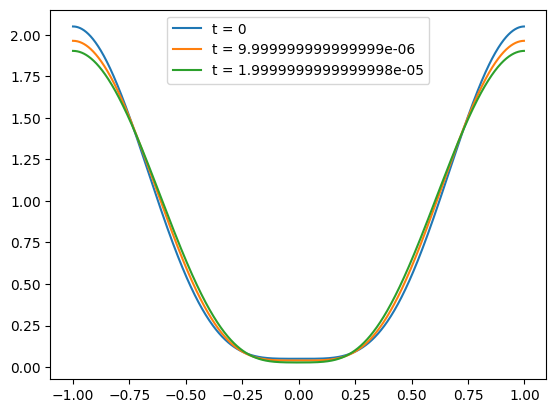

In [24]:
K = 1600

t1 = dt * 100

t2 = dt * 200

plt.plot(x, h0, label="t = 0")
plt.plot(x, sampled_sol[0], label=f"t = {t1}")
plt.plot(x, sampled_sol[1], label=f"t = {t2}")

plt.legend()
